In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import sys
sys.path.append('../')

from utils.processing import *
from utils.visualisation import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer


np.random.seed(0)

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 80)

In [4]:
# load data set
df = pd.read_csv('../data/train.csv')
df_train = df.copy()

df_train.iloc[0]

listing_id                                                                                     122881
title                                                       hdb flat for sale in 866 yishun street 81
address                                                                      sembawang / yishun (d27)
property_name                                                                    866 yishun street 81
property_type                                                                             hdb 4 rooms
tenure                                                                                            NaN
built_year                                                                                     1988.0
num_beds                                                                                          3.0
num_baths                                                                                         2.0
size_sqft                                                                         

In [5]:
# Utility functions

def prepare_data_for_regression(df, drop_columns=[]):
    adfs = read_aux_csv('../data')
    df = join_aux(df, adfs)
    df = df.drop(columns=drop_columns)

    return df

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    score = np.sqrt(mse)
    return score

def rmse_scorer():
    return make_scorer(rmse, greater_is_better=False)

# Constants
initial_drop_columns = [
        'address',
        'title',
        'listing_id',
        'property_name',
        'available_unit_types',
        'property_details_url',
        'elevation',
        'tenure',
        'property_type',
        'floor_level',
        'furnishing',
    ]

In [6]:
df_train = preprocess(df_train)
df_train = prepare_data_for_regression(df_train, drop_columns=initial_drop_columns)
df_train.head()

,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,price,property_type_private,property_type_public,tenure_high_year,tenure_low_year,floor_level_ground,floor_level_high,floor_level_low,floor_level_mid,floor_level_penthouse,floor_level_top,furnishing_partial,furnishing_unfurnished,furnishing_unspecified,nearest_mrt_distance_in_km,line_cc,line_ce,line_cg,line_dt,line_ew,line_ne,line_ns,line_te,nearest_pri_sch_distance_in_km,nearest_gep_pri_sch_distance_in_km,gep_pri_sch_within_1km,gep_pri_sch_within_1km_2km,gep_pri_sch_outside_2km,pri_sch_within_500m,pri_sch_outside_500m,nearest_com_centre_distance_in_km,cc_type_BN,cc_type_CR,cc_type_IEBP,cc_type_IHL,nearest_mall_distance_in_km,area_size,population,density,region
0,1988.0,3.0,2.0,1115.0,116.0,1.414399,103.837196,yishun south,yishun,514500.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.574204,0,0,0,0,0,0,1,0,0.275582,6.194099,0,0,1,1,0,3.338999,0,1,0,0,0.621334,1.3402,42240,31517.683928,n
1,1992.0,4.0,2.0,1575.0,NaN,1.372597,103.875625,serangoon north,serangoon,995400.0,0,1,0,1,0,0,0,0,0,0,0,0,1,1.734303,0,0,0,0,0,1,0,0,0.122925,0.122925,1,0,0,1,0,2.401882,1,0,0,0,0.552544,0.6847,15940,23280.268731,ne
2,2022.0,4.0,6.0,3070.0,56.0,1.298773,103.895798,mountbatten,marine parade,8485000.0,1,0,1,0,0,0,1,0,0,0,1,0,0,1.319766,1,0,0,0,0,0,0,0,0.891475,1.872702,0,1,0,0,1,2.171328,1,0,0,0,0.824208,1.7119,9980,5829.779777,c
3,2023.0,3.0,2.0,958.0,638.0,1.312364,103.803271,farrer court,bukit timah,2626000.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.726006,1,0,0,0,0,0,0,0,1.090371,1.090371,0,1,0,0,1,1.605928,1,0,0,0,0.907063,0.5588,6180,11059.413028,c
4,2026.0,2.0,1.0,732.0,351.0,1.273959,103.843635,anson,downtown core,1764000.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.371115,0,0,0,0,1,0,0,0,0.464835,2.742534,0,0,1,1,0,1.869574,0,1,0,0,0.430415,0.1032,80,775.193798,c


In [7]:
X_train = df_train.drop('price', axis=1)
y_train = df_train['price']

In [8]:
ct = make_column_transformer(
                    (make_pipeline(StandardScaler(), KNNImputer()), ['num_beds', 'num_baths', 'built_year', 'total_num_units']),
                    (StandardScaler(), ['nearest_mrt_distance_in_km', 'nearest_pri_sch_distance_in_km', 'nearest_gep_pri_sch_distance_in_km', 'nearest_com_centre_distance_in_km', 'nearest_mall_distance_in_km', 'area_size', 'population', 'density']),
                    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ["region", "subzone", "planning_area"]),
                    remainder='passthrough')

def ttr(pipeline):
    return TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

def transform_data(df):
    p = make_pipeline(ct)
    p.fit(df)
    
    return pd.DataFrame(data=p.transform(df), columns=p.get_feature_names_out())

In [9]:
transformed_X = transform_data(X_train)
transformed_X.head()

,pipeline__num_beds,pipeline__num_baths,pipeline__built_year,pipeline__total_num_units,standardscaler__nearest_mrt_distance_in_km,standardscaler__nearest_pri_sch_distance_in_km,standardscaler__nearest_gep_pri_sch_distance_in_km,standardscaler__nearest_com_centre_distance_in_km,standardscaler__nearest_mall_distance_in_km,standardscaler__area_size,standardscaler__population,standardscaler__density,onehotencoder__region_c,onehotencoder__region_e,onehotencoder__region_n,onehotencoder__region_ne,onehotencoder__region_w,onehotencoder__subzone_admiralty,onehotencoder__subzone_alexandra hill,onehotencoder__subzone_alexandra north,onehotencoder__subzone_aljunied,onehotencoder__subzone_anak bukit,onehotencoder__subzone_anchorvale,onehotencoder__subzone_ang mo kio town centre,onehotencoder__subzone_anson,...,remainder__floor_level_high,remainder__floor_level_low,remainder__floor_level_mid,remainder__floor_level_penthouse,remainder__floor_level_top,remainder__furnishing_partial,remainder__furnishing_unfurnished,remainder__furnishing_unspecified,remainder__line_cc,remainder__line_ce,remainder__line_cg,remainder__line_dt,remainder__line_ew,remainder__line_ne,remainder__line_ns,remainder__line_te,remainder__gep_pri_sch_within_1km,remainder__gep_pri_sch_within_1km_2km,remainder__gep_pri_sch_outside_2km,remainder__pri_sch_within_500m,remainder__pri_sch_outside_500m,remainder__cc_type_BN,remainder__cc_type_CR,remainder__cc_type_IEBP,remainder__cc_type_IHL
0,-0.096413,-0.436932,-1.437729,-0.753828,-0.387375,-0.870002,0.992342,1.332502,-0.322523,-0.162035,0.851992,1.392520,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.683956,-0.436932,-1.185214,-0.881810,1.698473,-1.154203,-1.187419,0.454867,-0.451613,-0.410230,-0.264521,0.704546,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.683956,2.279106,0.708650,-0.928348,0.953139,0.276600,-0.559189,0.238947,0.058179,-0.021297,-0.517540,-0.752887,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,-0.096413,-0.436932,0.771778,0.764496,-0.114437,0.646883,-0.840072,-0.290565,0.213661,-0.457900,-0.678862,-0.316117,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.876783,-1.115941,0.961165,-0.070292,-0.752526,-0.517673,-0.246889,-0.043654,-0.680793,-0.630405,-0.937824,-1.175036,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [10]:
transformed_X[transformed_X.isna().any(axis=1)]

,pipeline__num_beds,pipeline__num_baths,pipeline__built_year,pipeline__total_num_units,standardscaler__nearest_mrt_distance_in_km,standardscaler__nearest_pri_sch_distance_in_km,standardscaler__nearest_gep_pri_sch_distance_in_km,standardscaler__nearest_com_centre_distance_in_km,standardscaler__nearest_mall_distance_in_km,standardscaler__area_size,standardscaler__population,standardscaler__density,onehotencoder__region_c,onehotencoder__region_e,onehotencoder__region_n,onehotencoder__region_ne,onehotencoder__region_w,onehotencoder__subzone_admiralty,onehotencoder__subzone_alexandra hill,onehotencoder__subzone_alexandra north,onehotencoder__subzone_aljunied,onehotencoder__subzone_anak bukit,onehotencoder__subzone_anchorvale,onehotencoder__subzone_ang mo kio town centre,onehotencoder__subzone_anson,...,remainder__floor_level_high,remainder__floor_level_low,remainder__floor_level_mid,remainder__floor_level_penthouse,remainder__floor_level_top,remainder__furnishing_partial,remainder__furnishing_unfurnished,remainder__furnishing_unspecified,remainder__line_cc,remainder__line_ce,remainder__line_cg,remainder__line_dt,remainder__line_ew,remainder__line_ne,remainder__line_ns,remainder__line_te,remainder__gep_pri_sch_within_1km,remainder__gep_pri_sch_within_1km_2km,remainder__gep_pri_sch_outside_2km,remainder__pri_sch_within_500m,remainder__pri_sch_outside_500m,remainder__cc_type_BN,remainder__cc_type_CR,remainder__cc_type_IEBP,remainder__cc_type_IHL


In [11]:
# https://guhanesvar.medium.com/feature-selection-based-on-mutual-information-gain-for-classification-and-regression-d0f86ea5262a
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(transformed_X, y_train)

In [12]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = transformed_X.columns
mutual_info.sort_values(ascending=False)[0:50]

remainder__size_sqft                                  2.301480
remainder__lat                                        2.034062
remainder__property_type_private                      1.995719
standardscaler__nearest_gep_pri_sch_distance_in_km    1.986528
remainder__lng                                        1.983431
standardscaler__nearest_pri_sch_distance_in_km        1.973621
standardscaler__nearest_com_centre_distance_in_km     1.919534
standardscaler__density                               1.913356
standardscaler__nearest_mall_distance_in_km           1.899104
standardscaler__nearest_mrt_distance_in_km            1.898563
standardscaler__population                            1.871865
pipeline__total_num_units                             1.850581
standardscaler__area_size                             1.784966
pipeline__built_year                                  1.662858
pipeline__num_beds                                    1.465533
pipeline__num_baths                                   1

<AxesSubplot: >

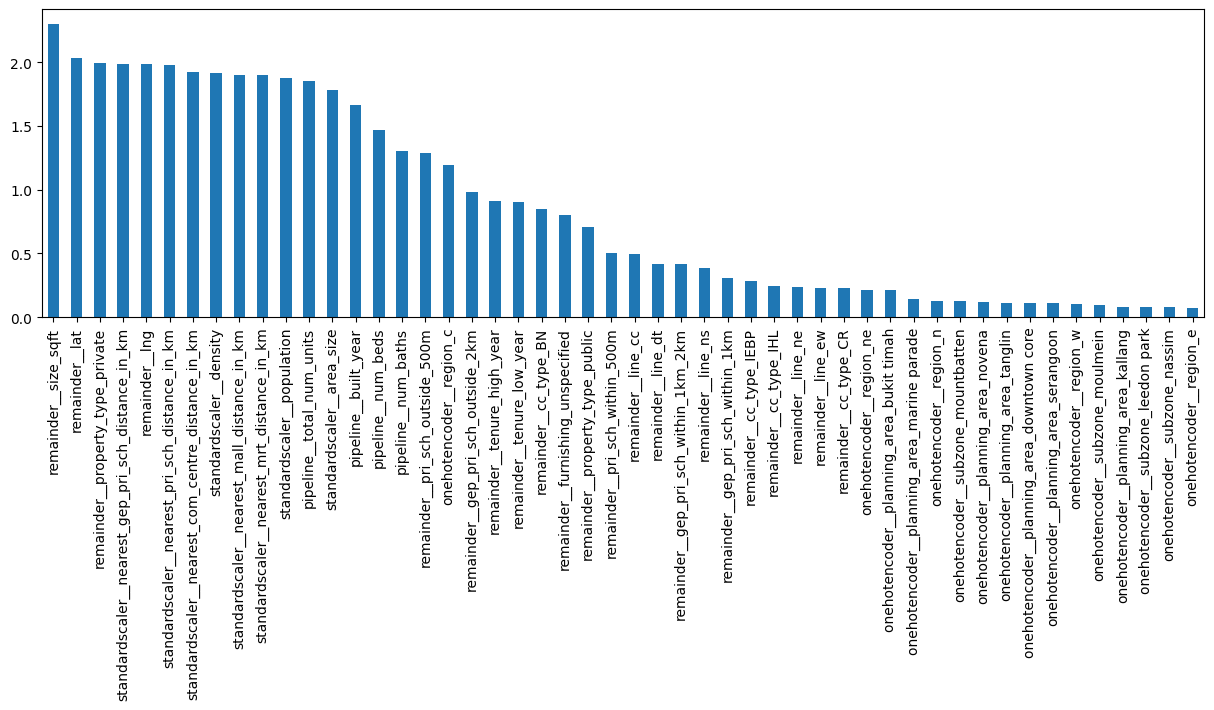

In [22]:
mutual_info.sort_values(ascending=False)[0:50].plot.bar(figsize=(15, 4))

In [14]:
mutual_info[mutual_info < 0.5].index

Index(['onehotencoder__region_e', 'onehotencoder__region_n',
       'onehotencoder__region_ne', 'onehotencoder__region_w',
       'onehotencoder__subzone_admiralty',
       'onehotencoder__subzone_alexandra hill',
       'onehotencoder__subzone_alexandra north',
       'onehotencoder__subzone_aljunied', 'onehotencoder__subzone_anak bukit',
       'onehotencoder__subzone_anchorvale',
       ...
       'remainder__line_dt', 'remainder__line_ew', 'remainder__line_ne',
       'remainder__line_ns', 'remainder__line_te',
       'remainder__gep_pri_sch_within_1km',
       'remainder__gep_pri_sch_within_1km_2km', 'remainder__cc_type_CR',
       'remainder__cc_type_IEBP', 'remainder__cc_type_IHL'],
      dtype='object', length=312)

In [15]:
list(map(lambda x: x.split('__')[1], mutual_info[mutual_info < 0.5].index))

['region_e',
 'region_n',
 'region_ne',
 'region_w',
 'subzone_admiralty',
 'subzone_alexandra hill',
 'subzone_alexandra north',
 'subzone_aljunied',
 'subzone_anak bukit',
 'subzone_anchorvale',
 'subzone_ang mo kio town centre',
 'subzone_anson',
 'subzone_balestier',
 'subzone_bangkit',
 'subzone_bayshore',
 'subzone_bedok north',
 'subzone_bedok reservoir',
 'subzone_bedok south',
 'subzone_bencoolen',
 'subzone_bendemeer',
 'subzone_bidadari',
 'subzone_bishan east',
 'subzone_boat quay',
 'subzone_boon keng',
 'subzone_boon lay place',
 'subzone_boon teck',
 'subzone_boulevard',
 'subzone_braddell',
 'subzone_bras basah',
 'subzone_brickworks',
 'subzone_bugis',
 'subzone_bukit batok central',
 'subzone_bukit batok east',
 'subzone_bukit batok south',
 'subzone_bukit batok west',
 'subzone_bukit ho swee',
 'subzone_bukit merah',
 'subzone_cairnhill',
 'subzone_cecil',
 'subzone_central subzone',
 'subzone_central water catchment',
 'subzone_changi airport',
 'subzone_changi poin